In [1]:
#!/usr/bin/env python
# encoding: utf-8
from __future__ import absolute_import, division, print_function, unicode_literals
# Install TensorFlow
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten , Convolution2D, MaxPooling2D , Lambda, Conv2D, Activation,Concatenate
from tensorflow.keras.layers import ActivityRegularization
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import regularizers , initializers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import NumpyArrayIterator


# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, remap_pids, to_categorical

gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
# Visible devices must be set before GPUs have been initialized
    print(e)



from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
# from xgboost import XGBClassifier
import tensorflow.keras.backend as K
from sklearn import metrics

# !pip3 install keras-tuner --upgrade
# !pip3 install autokeras
import kerastuner as kt
import autokeras as ak

#Plot's Making  Packages
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, MultipleLocator, AutoMinorLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
from matplotlib import cm
from matplotlib import font_manager


# Import local libraries
import numpy as np
import h5py
import time
import pandas as pd
import importlib
from scipy import interpolate
import os
from tqdm import tqdm 

import logging

importlib.reload(logging)
logging.basicConfig(level = logging.INFO)

os.environ['NUMEXPR_MAX_THREADS'] = '64'
os.environ['NUMEXPR_NUM_THREADS'] = '64'

print("Tensorflow Version is {}".format(tf.__version__))
print("Keras Version is {}".format(tf.keras.__version__))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.device('/device:XLA_GPU:0')
!nvidia-smi

%config InlineBackend. figure_format = 'retina'

Tensorflow Version is 2.4.1
Keras Version is 2.4.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18099019528845109170
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1048576000
locality {
  bus_id: 8
  numa_node: 7
  links {
  }
}
incarnation: 444086599880534454
physical_device_desc: "device: 0, name: A100-SXM-80GB, pci bus id: 0000:88:00.0, compute capability: 8.0"
]
Thu Jul 28 00:09:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======

In [2]:
filepath = "./"+str("pythia_vin")+"_KFold/PFN_"+str("pythia_vin")+"_Models_"+str(int(300))+str(int(500))+"/" + str("pythia_vin") + "_PFN_"+str(0)+ ".h5"
if os.path.exists(filepath):
#                     PFN_Model_A1[model] = load_model(filepath)

    model_PFN = load_model(filepath)
model_PFN.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    400         input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation[0][0]                 
______________________________________________________________________________________________

In [6]:
%%time

def dphi(phi,phi_c):

    dphi_temp = phi - phi_c
    while dphi_temp > np.pi:
        dphi_temp = dphi_temp - 2*np.pi
    while dphi_temp < -np.pi:
        dphi_temp = dphi_temp + 2*np.pi
    return (dphi_temp)

HOMEPATH = "/dicos_ui_home/alanchung/Universality_Boosetd_Higgs/"
data_PFN =  HOMEPATH + "Data_ML/" +"Data_PFN/"
savepath = HOMEPATH + "Data_ML/"



data_npz ={
#             "herwig_ang" : [0,0],
#             "pythia_def" : [0,0],
#             "pythia_vin" : [0,0],
            "pythia_dip" : [0,0],
#             "sherpa_def" : [0,0],
          }  

data_train = {
#             "herwig_ang_train" : 0,
#             "pythia_def_train" : 0,
#             "pythia_vin_train" : 0,
            "pythia_dip_train" : 0,
#             "sherpa_def_train" : 0
        }  


PFN_Model_A1 = {
      "herwig_ang" : 0,
      "pythia_def" : 0, 
      "pythia_vin" : 0, 
      "pythia_dip" : 0, 
#       "sherpa_def" : 0,
    }

       

"""
Loading Data
"""
logging.info("\r")
logging.info("Loading")
logging.info("###############")
ticks_1 = time.time()
for i, element in enumerate(data_npz):
    # np.load(data_PFN + str(element) + "_H.npz")["PFN_data_format"].shape(N, 300,
    # (N jets, 300 constituent's space, (cons.eta, cons.phi, cons.pt, cons.e, hj.eta, hj.phi, hj.pt, hj.e))
    data_npz[element][0] = np.load(data_PFN + str(element) + "_H.npz")["PFN_data_format"]
    data_npz[element][1] = np.load(data_PFN + str(element) + "_QCD.npz")["PFN_data_format"]
    
ticks_2 = time.time()
totaltime =  ticks_2 - ticks_1
logging.info("\n")
logging.info("\033[3;33mTime consumption : {:.4f} min\033[0;m".format(totaltime/60.))
logging.info("###############")


# """
# preprocess by centering jets and normalizing pts
# """
# logging.info("\r")
# logging.info("Preprocessing")
# logging.info("###############")
# ticks_1 = time.time()
# #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# for N in range(len(data_npz[element][0])):

#     # cons.eta - Jet.eta
#     data_npz[element][0][N, :, 0] = data_npz[element][0][N, :, 0] - data_npz[element][0][N, :, 4]

#     # dphi(cons.phi, Jet.phi)
#     for i in range(len(data_npz[element][0][N, :, 1])):
#         data_npz[element][0][N, i, 1] = dphi(data_train[element][N, i, 1], data_npz[element][0][N, i, 5])

#     # cons.pt/Jet.pt
#     data_npz[element][0][N, :, 2] = data_npz[element][0][N, :, 2]/data_npz[element][0][N, 0, 6]

    
    
# for N in range(len(data_npz[element][1])):

#     # cons.eta - Jet.eta
#     data_npz[element][1][N, :, 0] = data_npz[element][1][N, :, 0] - data_npz[element][1][N, :, 4]

#     # dphi(cons.phi, Jet.phi)
#     for i in range(len(data_npz[element][1][N, :, 1])):
#         data_npz[element][1][N, i, 1] = dphi(data_train[element][N, i, 1], data_npz[element][1][N, i, 5])

#     # cons.pt/Jet.pt
#     data_npz[element][1][N, :, 2] = data_npz[element][1][N, :, 2]/data_npz[element][1][N, 0, 6]
    
    
# #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# ticks_2 = time.time()
# totaltime =  ticks_2 - ticks_1
# logging.info("\n")
# logging.info("\033[3;33mTime consumption : {:.4f} min\033[0;m".format(totaltime/60.))
# logging.info("###############")
    
for j, (traindata, npz_element) in enumerate(zip(data_train, data_npz)):

    """
    Pt Range Study
    """
    for k, (pt_min, pt_max) in  enumerate(zip([300],[500])):

        train_data_path = HOMEPATH + "Notebook/KFold_PFN/" + str(traindata) + ".csv"
        if os.path.exists(train_data_path):
            tmp = pd.read_csv(train_data_path)
        else:
            raise ValueError("Pleas check training data path !!")

        tmp = tmp[(tmp["PTJ_0"] >= pt_min)  & (tmp["PTJ_0"] < pt_max)]
        tmp = tmp[(tmp["MJ_0"] >= 110)  & (tmp["MJ_0"] < 160)]
        data_train[traindata] = shuffle(tmp)
        H_tmp = data_train[traindata][data_train[traindata]["target"] == 1]
        QCD_tmp = data_train[traindata][data_train[traindata]["target"] == 0]

        H_PFN = data_npz[npz_element][0][H_tmp["index"].values]
        QCD_PFN = data_npz[npz_element][1][QCD_tmp["index"].values]

        data_train[traindata] = np.concatenate([H_PFN, QCD_PFN])
        target = np.concatenate([np.full(len(H_PFN),1), np.full(len(QCD_PFN),0)])
        data_train[traindata], target = shuffle(data_train[traindata], target)

        target= to_categorical(target, num_classes=2)

        """
        preprocess by centering jets and normalizing pts
        """
        logging.info("\r")
        logging.info("Preprocessing")
        logging.info("###############")
        ticks_1 = time.time()
        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        for N in range(len(data_train[traindata])):

            # cons.eta - Jet.eta
            data_train[traindata][N, :, 0] = data_train[traindata][N, :, 0] - data_train[traindata][N, :, 4]

            # dphi(cons.phi, Jet.phi)
            for i in range(len(data_train[traindata][N, :, 1])):
                data_train[traindata][N, i, 1] = dphi(data_train[traindata][N, i, 1], data_train[traindata][N, i, 5])

            # cons.pt/Jet.pt
            data_train[traindata][N, :, 2] = data_train[traindata][N, :, 2]/data_train[traindata][N, 0, 6]

        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        ticks_2 = time.time()
        totaltime =  ticks_2 - ticks_1
        logging.info("\n")
        logging.info("\033[3;33mTime consumption : {:.4f} min\033[0;m".format(totaltime/60.))
        logging.info("###############")

        kf = KFold(n_splits = 50)

        logging.info("Test Data: {}".format(traindata))
        time.sleep(0.5)
        for model_index, (train_index, val_index) in enumerate(kf.split(target)):
            ticks_1 = time.time()

            x_train, target_train = data_train[traindata][:,:,:3][train_index], target[train_index]
            x_val, target_val = data_train[traindata][:,:,:3][val_index], target[val_index]
                
            for i, model in enumerate(PFN_Model_A1): 
#                 logging.info("PFN Model: {}".format(model))




                Performance_Frame = {
                "AUC" : [0],
                "max_sig" : [0],
                "r05" : [0],
                "time": [0]
                }


                filepath = "./"+str(model)+"_KFold/PFN_"+str(model)+"_Models_"+str(int(pt_min))+str(int(pt_max))+"/" + str(model) + "_PFN_"+str(model_index)+ ".h5"
                if os.path.exists(filepath):
                    
                    model_PFN = load_model(filepath)

                    prediction_test =  model_PFN.predict(np.asarray(x_val))
                    discriminator_test = prediction_test[:,1]
                    discriminator_test = discriminator_test/(max(discriminator_test))

                    Performance_Frame["AUC"][0] = metrics.roc_auc_score(np.asarray(target_val)[:,1], discriminator_test)
                    FalsePositiveFull, TruePositiveFull, _ = metrics.roc_curve(np.asarray(target_val)[:,1], discriminator_test)
                    tmp = np.where(FalsePositiveFull != 0)
                    Performance_Frame["max_sig"][0] = max(TruePositiveFull[tmp]/np.sqrt(FalsePositiveFull[tmp])) 
                    tmp = np.where(TruePositiveFull >= 0.5)
                    Performance_Frame["r05"][0]= 1./FalsePositiveFull[tmp[0][0]]

                    Performance_Frame["time"][0] = (time.time() - ticks_1)/60.

                    dataframe = pd.DataFrame(Performance_Frame)



                    csvdata_path = "./"+str(model)+"_KFold/PFN_"+str(model)+"_Performance_Table_to_"+str(traindata)+"_"+str(pt_min)+str(pt_max)+".csv"
                    if os.path.exists(csvdata_path):
                        save_to_csvdata = pd.read_csv(csvdata_path)
                        DATA = pd.concat([save_to_csvdata, dataframe], ignore_index=True, axis=0,join='inner')
                        DATA.to_csv(csvdata_path, index = 0)

                    else:
                        dataframe.to_csv(csvdata_path, index = 0)
                    
                    h5_path = "./"+str(model)+"_KFold/PFN_"+str(model)+"_Performance_Table_to_"+str(traindata)+"_"+str(pt_min)+str(pt_max)+".h5"
                    if os.path.exists(h5_path):
                        save_to_hf = h5py.File(h5_path, 'r+')
                        save_to_hf.create_dataset("prediction_test_" + str(model_index), data=prediction_test, compression="gzip", compression_opts=5)
                        save_to_hf.create_dataset("discriminator_test_" + str(model_index), data=discriminator_test, compression="gzip", compression_opts=5)
                        save_to_hf.create_dataset("FalsePositiveFull_" + str(model_index), data=FalsePositiveFull, compression="gzip", compression_opts=5)
                        save_to_hf.create_dataset("TruePositiveFull_" + str(model_index), data=TruePositiveFull, compression="gzip", compression_opts=5)
                        save_to_hf.create_dataset("target_val_" + str(model_index), data=target_val, compression="gzip", compression_opts=5)
                        save_to_hf.close()

                    else:
                        save_to_hf = h5py.File(h5_path, 'w')
                        save_to_hf.create_dataset("prediction_test_" + str(model_index), data=prediction_test, compression="gzip", compression_opts=5)
                        save_to_hf.create_dataset("discriminator_test_" + str(model_index), data=discriminator_test, compression="gzip", compression_opts=5)
                        save_to_hf.create_dataset("FalsePositiveFull_" + str(model_index), data=FalsePositiveFull, compression="gzip", compression_opts=5)
                        save_to_hf.create_dataset("TruePositiveFull_" + str(model_index), data=TruePositiveFull, compression="gzip", compression_opts=5)
                        save_to_hf.create_dataset("target_val_" + str(model_index), data=target_val, compression="gzip", compression_opts=5)
                        save_to_hf.close()


                else:
                    raise ValueError("Pleas check model path !!")


        logging.info("There are {} events for each test.".format(len(target_val)))
        logging.info("{} PFN models apply on {} is finished!!".format(model,traindata))
        logging.info("END===========================================END")
        logging.info("\n")


logging.info("\n")
logging.info("\n")


INFO:root:
INFO:root:Loading
INFO:root:###############
INFO:root:

INFO:root:Time consumption : 3.2048 min
INFO:root:###############
INFO:root:
INFO:root:Preprocessing
INFO:root:###############
INFO:root:

INFO:root:Time consumption : 2.3880 min
INFO:root:###############
INFO:root:Test Data: pythia_dip_train
INFO:root:There are 6149 events for each test.
INFO:root:pythia_dip PFN models apply on pythia_dip_train is finished!!
INFO:root:END===========================================END
INFO:root:

INFO:root:

INFO:root:



CPU times: user 7min 23s, sys: 26.4 s, total: 7min 49s
Wall time: 7min 39s


In [25]:
%%time
PFN_Model_A1 = {
              "herwig_ang" : 0,
#               "pythia_def" : 0, 
#               "pythia_vin" : 0, 
#               "pythia_dip" : 0, 
#               "sherpa_def" : 0,
            }

Performance_Frame = {
            "herwig_ang_train" : 0,
            "pythia_def_train" : 0,
            "pythia_vin_train" : 0,
            "pythia_dip_train" : 0,
        }  

        
# index=["Herwig Angular", "Pythia Default", "Pythia Vincia", "Pythia Dipole", "Average", "STD"]

for i, model in enumerate(PFN_Model_A1): 
    logging.info("PFN Model: {} ".format(model))
    

    
    for j, element in enumerate(Performance_Frame): 
        
        Performance = {
                    "AUC" : [0,0,0,0,0,0],
                    "AUC std" : [0,0,0,0,0,0],
                    "max_sig" : [0,0,0,0,0,0],
                    "max_sig std" : [0,0,0,0,0,0],
                    "r05" : [0,0,0,0,0,0],
                    "r05 std" : [0,0,0,0,0,0],
                    "time": [0,0,0,0,0,0],
                    "time std" : [0,0,0,0,0,0],
                    }

    
#         for k, (pt_min, pt_max) in  enumerate(zip([300,400,500,600,700,800],[400,500,600,700,800,900])):
        for k, (pt_min, pt_max) in  enumerate(zip([300],[500])):
            Performance_Table = pd.read_csv("./"+str(model)+"_KFold/PFN_"+str(model)+"_Performance_Table_to_"+str(element)+"_"+str(pt_min)+str(pt_max)+".csv")
#             Performance_Table = pd.read_csv("./"+str(model)+"_KFold/PFN_"+str(model)+"_Performance_Table_to_"+str(element)+"_"+str(pt_min)+str(pt_max)+".csv")
            
            logging.info(len(Performance_Table))

            Performance_Table.drop(Performance_Table[Performance_Table["AUC"] <= 0.7].index, inplace=True)
            Performance_Table.drop(Performance_Table[Performance_Table["AUC"] == 1].index, inplace=True)
            Performance["AUC"][k] = Performance_Table["AUC"].mean()
            Performance["AUC std"][k] = Performance_Table["AUC"].std()
            Performance["max_sig"][k] = Performance_Table["max_sig"].mean()
            Performance["max_sig std"][k] = Performance_Table["max_sig"].std()
            Performance["r05"][k] = Performance_Table["r05"].mean()
            Performance["r05 std"][k] = Performance_Table["r05"].std()
            Performance["time"][k] = Performance_Table["time"].mean()
            Performance["time std"][k] = Performance_Table["time"].std()



#         Performance_Frame[element] = pd.DataFrame(Performance,
#                      index=["pt300400","pt400500","pt500600","pt600700","pt700800","pt800900"]
#                     )
        
        Performance_Frame[element] = pd.DataFrame(Performance,
                     index=["pt3001100","null","null","null","null","null"]
                    )

INFO:root:PFN Model: herwig_ang 
INFO:root:50
INFO:root:50
INFO:root:50
INFO:root:50


CPU times: user 28.2 ms, sys: 1.04 ms, total: 29.3 ms
Wall time: 29 ms


In [8]:
Performance_Frame["herwig_ang_train"]

,AUC,AUC std,max_sig,max_sig std,r05,r05 std,time,time std
pt3001100,0.911393,0.018122,5.250062,1.381307,28.356937,5.174446,0.02073,0.001944
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


In [9]:
Performance_Frame["pythia_def_train"]

,AUC,AUC std,max_sig,max_sig std,r05,r05 std,time,time std
pt3001100,0.874666,0.025256,2.22784,0.460307,15.76691,3.085099,0.020699,0.001383
null,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000


In [10]:
Performance_Frame["pythia_vin_train"]

,AUC,AUC std,max_sig,max_sig std,r05,r05 std,time,time std
pt3001100,0.899717,0.025656,3.454886,1.220911,24.149995,5.365962,0.020187,0.001322
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [11]:
Performance_Frame["pythia_dip_train"]

,AUC,AUC std,max_sig,max_sig std,r05,r05 std,time,time std
pt3001100,0.891305,0.021197,2.694449,0.691744,20.448198,3.838712,0.0242,0.006021
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000


In [12]:
metric = "AUC"

print(np.mean([Performance_Frame["herwig_ang_train"][metric],Performance_Frame["pythia_def_train"][metric],Performance_Frame["pythia_vin_train"][metric],Performance_Frame["pythia_dip_train"][metric]], axis=0))
print(np.std([Performance_Frame["herwig_ang_train"][metric],Performance_Frame["pythia_def_train"][metric],Performance_Frame["pythia_vin_train"][metric],Performance_Frame["pythia_dip_train"][metric]], axis=0))



[0.89427025 0.         0.         0.         0.         0.        ]
[0.0133792 0.        0.        0.        0.        0.       ]


In [39]:
%%time
PFN_Model_A1 = {
              "herwig_ang" : 0,
              "pythia_def" : 0, 
              "pythia_vin" : 0, 
              "pythia_dip" : 0, 
#               "sherpa_def" : 0,
            }

Performance_Frame = {
            "herwig_ang_train" : 0,
            "pythia_def_train" : 0,
            "pythia_vin_train" : 0,
            "pythia_dip_train" : 0,
        }  

        
# index=["Herwig Angular", "Pythia Default", "Pythia Vincia", "Pythia Dipole", "Average", "STD"]

        
Performance_Summary = {
            "row1" : [0,0,0,0],
            "row2" : [0,0,0,0],
            "row3" : [0,0,0,0],
            "row4" : [0,0,0,0],
            "row5" : [0,0,0,0],
            }


    
for i, element in enumerate(Performance_Frame): 
    logging.info("test on {}".format(element))
        
    for j, model in enumerate(PFN_Model_A1): 
        logging.info("PFN Model: {} ".format(model))
        
        Performance = {
                    "AUC" : [0,0,0,0,0,0],
                    "AUC std" : [0,0,0,0,0,0],
                    "max_sig" : [0,0,0,0,0,0],
                    "max_sig std" : [0,0,0,0,0,0],
                    "r05" : [0,0,0,0,0,0],
                    "r05 std" : [0,0,0,0,0,0],
                    "time": [0,0,0,0,0,0],
                    "time std" : [0,0,0,0,0,0],
                    }

    
#         for k, (pt_min, pt_max) in  enumerate(zip([300,400,500,600,700,800],[400,500,600,700,800,900])):
        for k, (pt_min, pt_max) in  enumerate(zip([300],[500])):
            Performance_Table = pd.read_csv("./"+str(model)+"_KFold/PFN_"+str(model)+"_Performance_Table_to_"+str(element)+"_"+str(pt_min)+str(pt_max)+".csv")
#             Performance_Table = pd.read_csv("./"+str(model)+"_KFold/PFN_"+str(model)+"_Performance_Table_to_"+str(element)+"_"+str(pt_min)+str(pt_max)+".csv")
            
            logging.info(len(Performance_Table))

            Performance_Table.drop(Performance_Table[Performance_Table["AUC"] <= 0.7].index, inplace=True)
            Performance_Table.drop(Performance_Table[Performance_Table["AUC"] == 1].index, inplace=True)
            Performance["AUC"][k] = Performance_Table["AUC"].mean()
            Performance["AUC std"][k] = Performance_Table["AUC"].std()
            Performance["max_sig"][k] = Performance_Table["max_sig"].mean()
            Performance["max_sig std"][k] = Performance_Table["max_sig"].std()
            Performance["r05"][k] = Performance_Table["r05"].mean()
            Performance["r05 std"][k] = Performance_Table["r05"].std()
            Performance["time"][k] = Performance_Table["time"].mean()
            Performance["time std"][k] = Performance_Table["time"].std()



#         Performance_Frame[element] = pd.DataFrame(Performance,
#                      index=["pt300400","pt400500","pt500600","pt600700","pt700800","pt800900"]
#                     )
        
        PFN_Model_A1[model] = pd.DataFrame(Performance,
                     index=["pt3001100","null","null","null","null","null"]
                    )
        
        
    metric = "r05"
    for l, (row, model) in enumerate(zip(Performance_Summary,PFN_Model_A1)): 
            Performance_Summary[row][i] = "${:.4f}\pm{:.4f}$".format(PFN_Model_A1[model][metric][0],PFN_Model_A1[model][metric + " std"][0])
            
    ave = np.mean([PFN_Model_A1["herwig_ang"][metric],PFN_Model_A1["pythia_def"][metric],PFN_Model_A1["pythia_vin"][metric],PFN_Model_A1["pythia_dip"][metric]], axis=0)
    std = np.std([PFN_Model_A1["herwig_ang"][metric],PFN_Model_A1["pythia_def"][metric],PFN_Model_A1["pythia_vin"][metric],PFN_Model_A1["pythia_dip"][metric]], axis=0)
    
    Performance_Summary["row5"][i] = "${:.4f}\pm{:.4f}$".format(ave[0],std[0])

    

INFO:root:test on herwig_ang_train
INFO:root:PFN Model: herwig_ang 
INFO:root:50
INFO:root:PFN Model: pythia_def 
INFO:root:50
INFO:root:PFN Model: pythia_vin 
INFO:root:50
INFO:root:PFN Model: pythia_dip 
INFO:root:50
INFO:root:test on pythia_def_train
INFO:root:PFN Model: herwig_ang 
INFO:root:50
INFO:root:PFN Model: pythia_def 
INFO:root:50
INFO:root:PFN Model: pythia_vin 
INFO:root:50
INFO:root:PFN Model: pythia_dip 
INFO:root:50
INFO:root:test on pythia_vin_train
INFO:root:PFN Model: herwig_ang 
INFO:root:50
INFO:root:PFN Model: pythia_def 
INFO:root:50
INFO:root:PFN Model: pythia_vin 
INFO:root:50
INFO:root:PFN Model: pythia_dip 
INFO:root:50
INFO:root:test on pythia_dip_train
INFO:root:PFN Model: herwig_ang 
INFO:root:50
INFO:root:PFN Model: pythia_def 
INFO:root:50
INFO:root:PFN Model: pythia_vin 
INFO:root:50
INFO:root:PFN Model: pythia_dip 
INFO:root:50


CPU times: user 117 ms, sys: 10.4 ms, total: 127 ms
Wall time: 120 ms


In [40]:
# Format for latex
NAME = ["Herwig Angular", "Pythia Default", "Pythia Vincia", "Pythia Dipole", "Average $\pm$ Std."]
for (element, name) in zip(Performance_Summary, NAME):
    print("\\textbf{"+str(name)+"}","& {} & {} & {} & {}".format(Performance_Summary[element][0],Performance_Summary[element][1],Performance_Summary[element][2],Performance_Summary[element][3]))
    
    
    
    

\textbf{Herwig Angular} & $19.7245\pm1.9639$ & $23.3231\pm2.4638$ & $42.0133\pm4.6242$ & $31.3210\pm3.4449$
\textbf{Pythia Default} & $14.0366\pm1.0341$ & $56.3095\pm8.6969$ & $71.2582\pm11.6636$ & $48.4537\pm6.3326$
\textbf{Pythia Vincia} & $14.5762\pm1.1026$ & $36.4563\pm4.1258$ & $103.6878\pm24.2408$ & $48.1431\pm5.7317$
\textbf{Pythia Dipole} & $14.8573\pm1.2510$ & $35.8811\pm4.4897$ & $72.3224\pm13.1779$ & $67.0319\pm10.5225$
\textbf{Average $\pm$ Std.} & $15.7986\pm2.2857$ & $37.9925\pm11.8060$ & $72.3205\pm21.8149$ & $48.7374\pm12.6338$


In [103]:
# metric = "AUC"

# ave = np.mean([PFN_Model_A1["herwig_ang"][metric],PFN_Model_A1["pythia_def"][metric],PFN_Model_A1["pythia_vin"][metric],PFN_Model_A1["pythia_dip"][metric]], axis=0)
# std = np.std([PFN_Model_A1["herwig_ang"][metric],PFN_Model_A1["pythia_def"][metric],PFN_Model_A1["pythia_vin"][metric],PFN_Model_A1["pythia_dip"][metric]], axis=0)



# print("${:.2f}\pm{:.4f}$".format(PFN_Model_A1["herwig_ang"][metric][0],PFN_Model_A1["herwig_ang"][metric + " std"][0]))
# print("${:.2f}\pm{:.4f}$".format(PFN_Model_A1["pythia_def"][metric][0],PFN_Model_A1["pythia_def"][metric + " std"][0]))
# print("${:.2f}\pm{:.4f}$".format(PFN_Model_A1["pythia_vin"][metric][0],PFN_Model_A1["pythia_vin"][metric + " std"][0]))
# print("${:.2f}\pm{:.4f}$".format(PFN_Model_A1["pythia_dip"][metric][0],PFN_Model_A1["pythia_dip"][metric + " std"][0]))
# print("${:.2f}\pm{:.4f}$".format(ave[0],std[0]))


$0.90\pm0.0035$
$0.91\pm0.0033$
$0.91\pm0.0032$
$0.91\pm0.0035$
$0.91\pm0.0020$


In [3]:
pt_min = 300
pt_max = 500

## ROC Curves

INFO:root:PFN Model: herwig_ang
INFO:root:END===========================================END
INFO:root:

INFO:root:PFN Model: pythia_def
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:94: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:104: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
INFO:root:END===========================================END
INFO:root:

INFO:

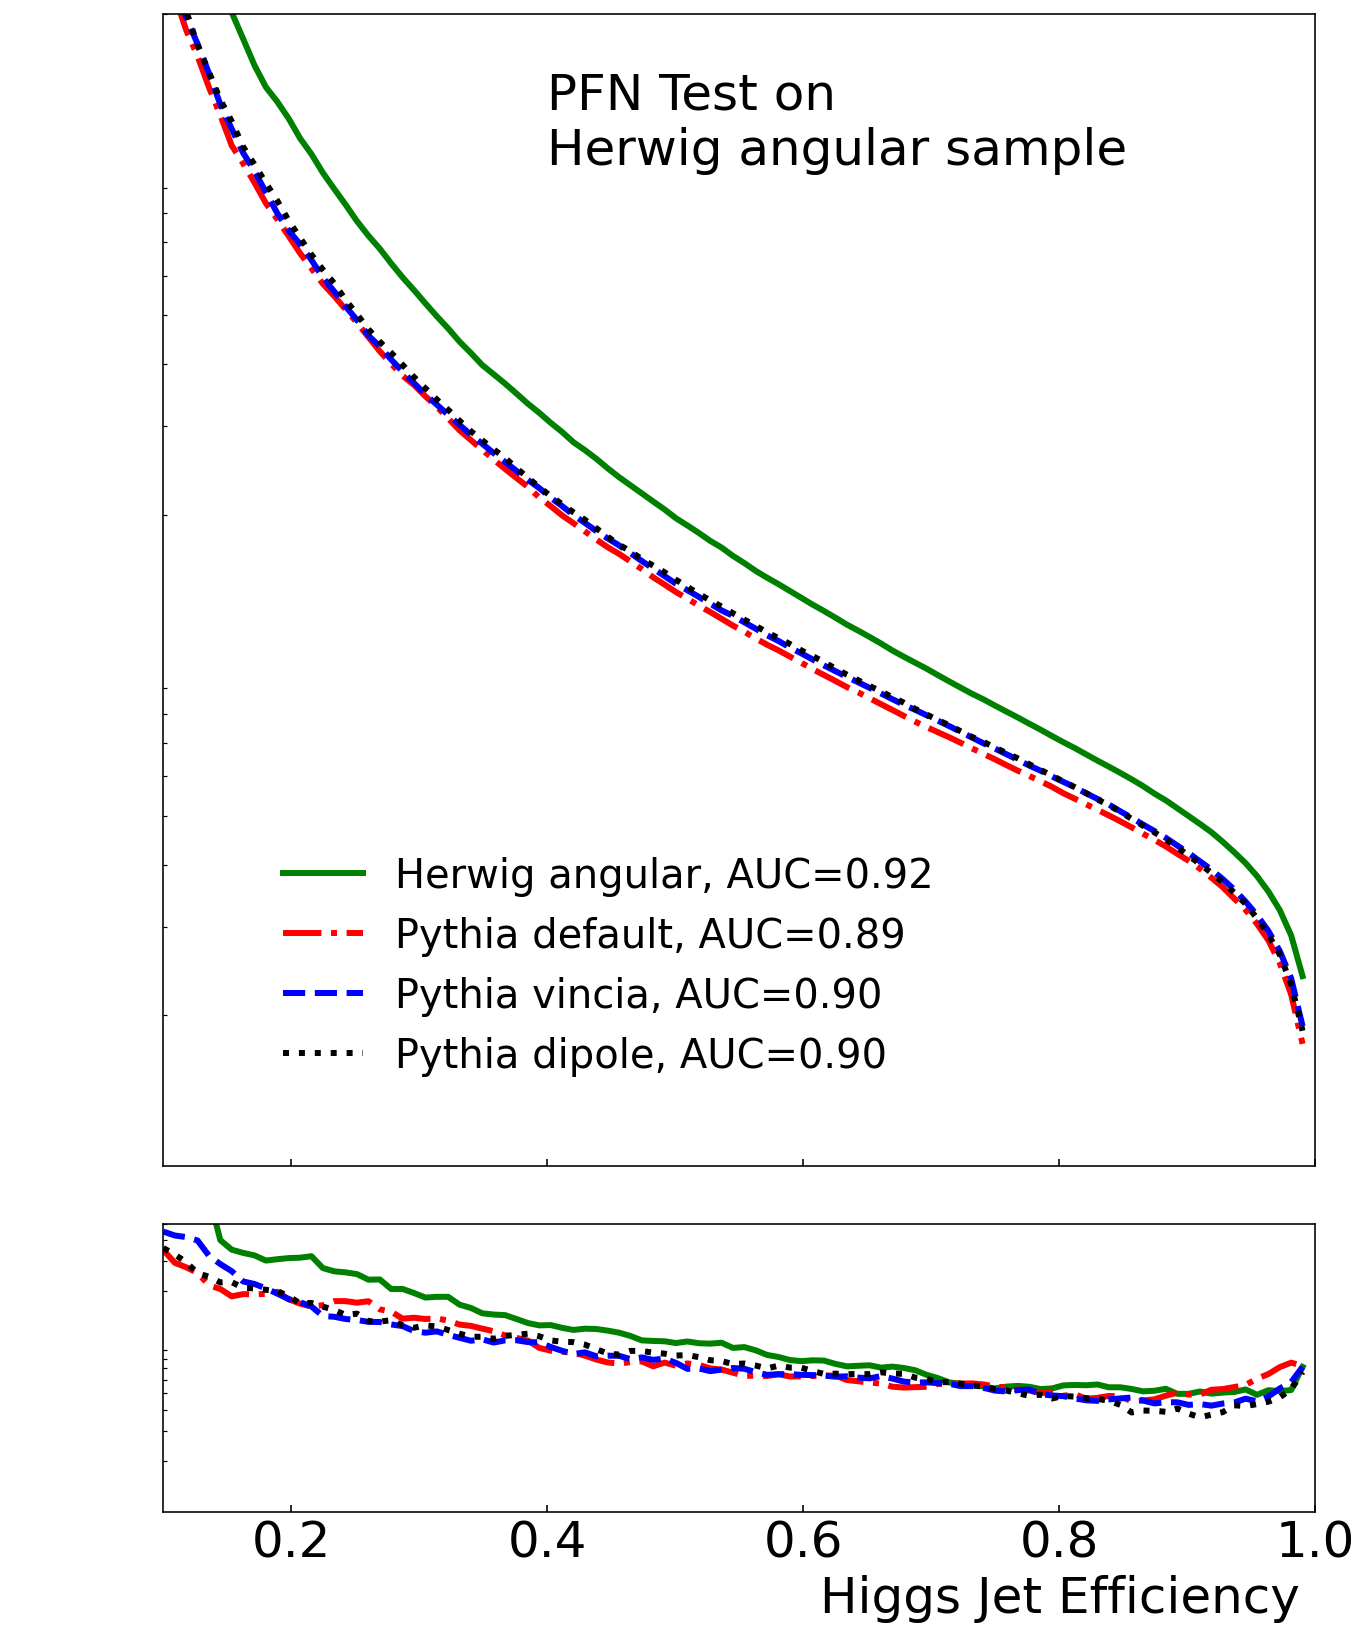

CPU times: user 2.12 s, sys: 112 ms, total: 2.23 s
Wall time: 2.23 s


In [45]:
%%time
fix_model_or_fix_data = 1 # 0:fix model, 1:fix data


title = ["Herwig angular", "Pythia default", "Pythia vincia", "Pythia dipole"]

colors = ["green","red","blue","black"]
linestyle = ["-","-.","--",":"]


data_train = {
        "herwig_ang_train" : {"index":0, "data":0},
#         "pythia_def_train" : {"index":1, "data":0},
#         "pythia_vin_train" : {"index":2, "data":0},
#         "pythia_dip_train" : {"index":3, "data":0},
        }  

PFN_Model_A1 = {
      "herwig_ang" : 0,
      "pythia_def" : 1, 
      "pythia_vin" : 2, 
      "pythia_dip" : 3, 
    }

# fig, ax = plt.subplots(1,1, figsize=(8,8)) 
fig = plt.figure(figsize=(8,8))
for i, model in enumerate(PFN_Model_A1): 
    logging.info("PFN Model: {}".format(model))

    for j, traindata in enumerate(data_train):

        Performance_Frame = {
        "AUC" : np.zeros(50),
        "max_sig" : [0],
        "r05" : [0],
        "time": [0]
        }

        
        filepath = "./"+str(model)+"_KFold/PFN_"+str(model)+"_Performance_Table_to_"+str(traindata)+"_"+str(pt_min)+str(pt_max)+".h5"
        if os.path.exists(filepath):
            hf_read = h5py.File(filepath, 'r')
            
            FalsePositiveFull_inverse_array = []
            for k in range(50):
#                 prediction_test =  hf_read.get("prediction_test_"+str(k))
                discriminator_test =  hf_read.get("discriminator_test_"+str(k))
            

                Performance_Frame["AUC"][k] = metrics.roc_auc_score(hf_read.get("target_val_"+str(k))[:,1], discriminator_test)
                FalsePositiveFull, TruePositiveFull = hf_read.get("FalsePositiveFull_"+str(k))[:], hf_read.get("TruePositiveFull_"+str(k))[:]
                
#                 """
#                 Remove Duplicated Index: Method 1
#                 """
#                 TruePositiveFull_ = [(element+TruePositiveFull[i+1])/2 for i, element in enumerate(TruePositiveFull) if i+1 < len(TruePositiveFull)]
#                 FalsePositiveFull_ = [(element+FalsePositiveFull[i+1])/2 for i, element in enumerate(FalsePositiveFull) if i+1 < len(FalsePositiveFull)]
#                 TruePositiveFull_ = [(element+TruePositiveFull_[i+1])/2 for i, element in enumerate(TruePositiveFull_) if i+1 < len(TruePositiveFull_)]
#                 FalsePositiveFull_ = [(element+FalsePositiveFull_[i+1])/2 for i, element in enumerate(FalsePositiveFull_) if i+1 < len(FalsePositiveFull_)]
#                 TruePositiveFull_ = [(element+TruePositiveFull_[i+1])/2 for i, element in enumerate(TruePositiveFull_) if i+1 < len(TruePositiveFull_)]
#                 FalsePositiveFull_ = [(element+FalsePositiveFull_[i+1])/2 for i, element in enumerate(FalsePositiveFull_) if i+1 < len(FalsePositiveFull_)]
                
                """
                Remove Duplicated Index: Method 2
                """
                without_duplicat_index = [i for i, element in enumerate(TruePositiveFull) if i+1 < len(TruePositiveFull) if element!= TruePositiveFull[i+1] ]
                TruePositiveFull_ = TruePositiveFull[without_duplicat_index]
                FalsePositiveFull_ = FalsePositiveFull[without_duplicat_index]
                
                
                curve_fit = interpolate.interp1d(TruePositiveFull_, FalsePositiveFull_,kind='previous')
                plot_range = np.linspace(0.1,0.99,101)
                FalsePositiveFull_inverse_array.append(1./curve_fit(plot_range))
            
#             tmp = np.where(FalsePositiveFull != 0)
#             Performance_Frame["max_sig"][0] = max(TruePositiveFull[tmp]/np.sqrt(FalsePositiveFull[tmp])) 
#             tmp = np.where(TruePositiveFull >= 0.5)
#             Performance_Frame["r05"][0]= 1./FalsePositiveFull[tmp[0][0]]

#             Performance_Frame["time"][0] = (time.time() - ticks_1)/60.

            FalsePositiveFull_inverse_array = np.array(FalsePositiveFull_inverse_array)
            FalsePositiveFull_inverse_average = np.average(FalsePositiveFull_inverse_array, axis=0)
            FalsePositiveFull_inverse_std = np.std(FalsePositiveFull_inverse_array, axis=0)
    
    
            if fix_model_or_fix_data == 0:
                plot_index = j
            elif fix_model_or_fix_data == 1:
                plot_index = i
            else:
                raise ValueError("Pleas check model fixed or data fixed !!")

            if np.average(Performance_Frame["AUC"]) >= 0.7:
                frame1=fig.add_axes((0,0.3,1,1))
                frame1.plot(
                         plot_range, FalsePositiveFull_inverse_average,
                         linewidth = 3,
                         ls=linestyle[plot_index], 
                         color=colors[plot_index], 
#                          label="%s, AUC=%.2f $\pm$ %.3f" % (title[plot_index],np.average(Performance_Frame["AUC"]),np.std(Performance_Frame["AUC"]))
                         label="%s, AUC=%.2f" % (title[plot_index],np.average(Performance_Frame["AUC"]))
                        )
                
                frame2=fig.add_axes((0,0, 1, 0.25)) 
                frame2.plot(
                         plot_range, FalsePositiveFull_inverse_std/FalsePositiveFull_inverse_average*100,
                         linewidth = 3,
                         ls=linestyle[plot_index], 
                         color=colors[plot_index], 
                           )
            else:
                pass


        else:
            raise ValueError("Pleas check model path !!")

#             plt.xlim((0.1,1))
#             plt.ylim((1, 2E+2))
#             plt.yscale("log")
#             plt.show()

#     logging.info("There are {} events for each test.".format(len(hf_read.get("target_val_0"))))
#     logging.info("{} PFN models apply on {} is finished!!".format(model,traindata))
    logging.info("END===========================================END")
    logging.info("\n")

            
            
            
    
    if fix_model_or_fix_data == 0:
        frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
        # frame1.tick_params(axis='x', labelsize=25, rotation=45)
        # frame1.xaxis.set_major_locator(MaxNLocator(10)) 
        frame1.tick_params(which='both', labelsize=25, direction = "in")
        frame1.tick_params(axis='y', labelsize=25, direction = "in")
        frame1.set_xlim((0.1,1))
        frame1.set_ylim((1, 2E+2))
        frame1.set_yscale("log")
        frame1.set_ylabel('1/[QCD Jet Rejection]', fontsize=25,horizontalalignment='right',y=1) 
        frame1.legend(bbox_to_anchor=(0.4, 1),ncol=1,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0) #bbox_to_anchor=(0.7, 0.1)
        frame1.text(0.2,2,"%s model \nTest on different data" % title[PFN_Model_A1[model]], fontsize=20)

        frame2.tick_params(axis='x', labelsize=25, direction = "in") 
        frame2.tick_params(axis='y', labelsize=25, direction = "in")
    #     frame2.tick_params(which='major', labelsize=25, direction = "in")
    #     frame2.yaxis.get_ticklocs(minor=True)
        frame2.yaxis.set_minor_locator(MultipleLocator(10)) 
        frame2.set_xlim((0.1,1)) #Change PFN_Model_A1
        frame2.set_ylim((1, 1E+2)) #Change PFN_Model_A1
        frame2.set_yscale("log") #Change PFN_Model_A1
        frame2.set_xlabel('Higgs Jet Efficiency ', fontsize=25,horizontalalignment='right',x=1) 
        frame2.set_ylabel('R.U. (%)', fontsize=25,horizontalalignment='right',y=1)
#         plt.savefig("/dicos_ui_home/alanchung/Universality_Boosetd_Higgs/Notebook/Plots/"+str(model)+"_model_change_data_PFN.pdf", transparent=True, bbox_inches='tight')
        plt.show() #Change data_train



        logging.info("\n")
        logging.info("\n")
    else:
        pass
    
    
if fix_model_or_fix_data == 1:
    frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
    # frame1.tick_params(axis='x', labelsize=25, rotation=45)
    # frame1.xaxis.set_major_locator(MaxNLocator(10)) 
    frame1.tick_params(which='both', labelsize=25, direction = "in")
    frame1.tick_params(axis='y', labelsize=25, direction = "in", colors='white')
    frame1.set_xlim((0.1,1))
    frame1.set_ylim((1, 2E+2))
    frame1.set_yscale("log")
    frame1.set_ylabel('1/[QCD Jet Rejection]', fontsize=25,horizontalalignment='right',y=1, color='white') 
    frame1.legend(bbox_to_anchor=(0.7, 0.3),ncol=1,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0) #bbox_to_anchor=(0.7, 0.1)
    frame1.text(0.4,100,"PFN Test on \n%s sample" % title[data_train[traindata]["index"]], fontsize=25)
    
    
    
    
#     frame1.set_yticklabels([]) #Remove y-tic labels for the first frame
    
    
    
    
    frame2.tick_params(axis='x', labelsize=25, direction = "in") 
    frame2.tick_params(axis='y', labelsize=25, direction = "in", colors='white')
    frame2.tick_params(which='both', labelsize=25, direction = "in")
    
#     frame2.yaxis.get_ticklocs(minor=True)
    frame2.yaxis.set_minor_locator(MultipleLocator(10)) 
    frame2.set_xlim((0.1,1)) #Change PFN_Model_A1
    frame2.set_ylim((1, 5E+1)) #Change PFN_Model_A1
    frame2.set_yscale("log") #Change PFN_Model_A1
    frame2.set_xlabel('Higgs Jet Efficiency ', fontsize=25,horizontalalignment='right',x=1) 
    
#     frame2.set_yticklabels([]) #Remove y-tic labels for the first frame
#     frame2.set_ylabel('   ', fontsize=25,horizontalalignment='right',y=1)
    frame2.set_ylabel('R.U. (%)', fontsize=25,horizontalalignment='right',y=1, color='white') 
#     frame2.grid()
    plt.savefig("/dicos_ui_home/alanchung/Universality_Boosetd_Higgs/Notebook/Plots/change_model_"+str(traindata)[:10]+"_data_PFN.pdf", transparent=True, bbox_inches='tight')
    plt.show() 
    
else:
        pass




In [5]:
pt_min, pt_max = 300,500

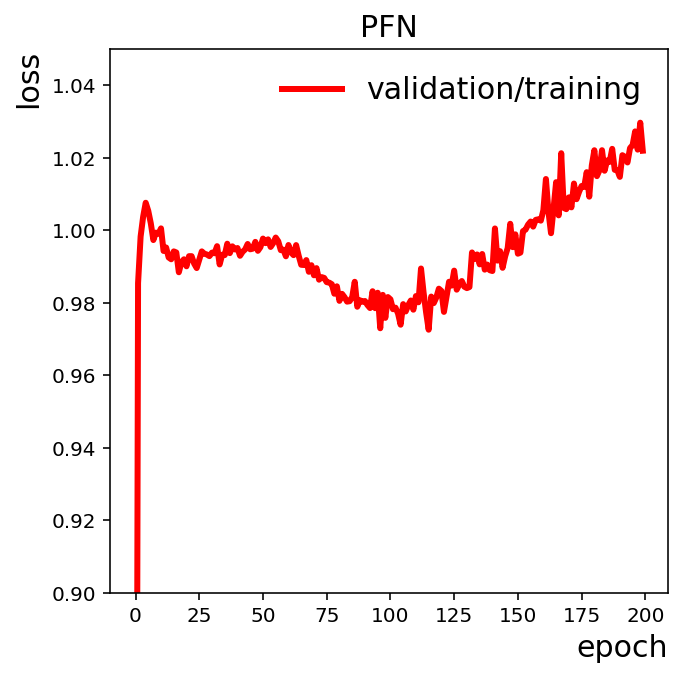

In [17]:

PFN_Model_A1 = {
      "herwig_ang" : 0,
      "pythia_def" : 1, 
      "pythia_vin" : 2, 
      "pythia_dip" : 3, 
    }
sample_type = "herwig_ang"

"""
Learning Curve
"""

HOMEPATH = "/dicos_ui_home/alanchung/Universality_Boosetd_Higgs/"
learning_curve = pd.read_csv(HOMEPATH + "Notebook/KFold_PFN/"+str(sample_type)+"_KFold/PFN_"+str(sample_type)+"_Models_300500/"+str(sample_type)+"_history_PFN_"+str(0)+".csv")

N = 50

loss_std = np.zeros((200,N))
val_loss_std = np.zeros((200,N))

for i in range(1,N):
    tmp_dataframe = pd.read_csv(HOMEPATH + "Notebook/KFold_PFN/"+str(sample_type)+"_KFold/PFN_"+str(sample_type)+"_Models_300500/"+str(sample_type)+"_history_PFN_"+str(i)+".csv")
    learning_curve +=  tmp_dataframe
    loss_std[:,i] = tmp_dataframe["loss"]
    val_loss_std[:,i] = tmp_dataframe["val_loss"]
    
learning_curve /= N
loss_std = loss_std.std(axis=1)
val_loss_std = val_loss_std.std(axis=1)
    
    
fig, ax = plt.subplots(1,1, figsize=(5,5))

# plt.plot(learning_curve["loss"], label='training data',c='blue',linewidth = 3)
# plt.plot(learning_curve["val_loss"], label='validation data',c='red',linewidth = 3)

plt.plot(learning_curve["val_loss"]/learning_curve["loss"], label='validation/training',c='red',linewidth = 3)

plt.title("PFN", fontsize=15)

plt.ylim((0.9,1.05))

ax.set_ylabel('loss', fontsize=15,horizontalalignment='right',y=1)
ax.set_xlabel('epoch', fontsize=15,horizontalalignment='right',x=1)
plt.legend(loc='best', prop={'size':15}, edgecolor = "w",fancybox=False, framealpha=0)


plt.show()